In [426]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [427]:
import sys
sys.path.append('../src/')

In [428]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [429]:
import random

### Environment

* define a grid with holes
* start position in upper left corner and goal in the lower right corner
* win: `position == goal; loss: position != goal`
* `if grid[position] == 0 then position == start`
* `steps == 20`
* `if position == goal then done==True`

In [430]:
grid = np.array([
    [1, 1, 0, 1, 1, 1, 1],
    [0, 1, 0, 1, 1, 0, 1],
    [1, 1, 1, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 0, 1, 1],
    [1, 1, 1, 1, 0, 1, 1]
])

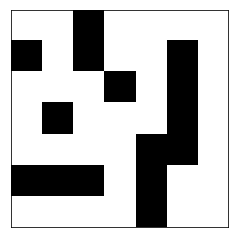

In [431]:
plt.imshow(grid, cmap='gray')
plt.yticks([])
plt.xticks([])
plt.show()

In [432]:
done = False
start = (0,0)
goal = (6,6)
steps = 20
win = False
position = start

In [433]:
moves = np.array([[-1, 0],
                    [1, 0],
                    [0, -1],
                    [0, 1]])

In [434]:
def observe(position):
    idx = np.where((moves + position).min(axis=1) >= 0)[0]
    return [(i,j) for i,j in moves[idx,:]+position if grid[i,j] >= 0]

In [435]:
observe(start)

[(1, 0), (0, 1)]

In [436]:
def action(next_position):
    if grid[next_position] == 0:
        position = start
    elif next_position == goal:
        win = True
    else:
        position = next_position
    return position

In [437]:
possible_positions = observe(position)

In [438]:
next_position = random.choice(possible_positions)

In [439]:
position = action(next_position)

In [440]:
position

(0, 1)

In [441]:
from mcts import GridEnv

In [442]:
wins = 0
for _ in range(1000):
    env = GridEnv()
    for i in range(22):
        if not env.done:
            possible_position = env.observe()
            next_position = random.choice(possible_position)
            env.action(next_position)
            if env.win:
                wins += 1


In [443]:
wins

0

### Monte Carlo Tree Search

* Analysis of the most promizing move toward a goal.
* session are played until the end by selecting random moves
* the session result is used to weight nodes of the actions tree

#### Algorithm

* _Selection_ : choose most promizing child nodes starting from the root _(R)_ of the tree until one of the leaf node _(L)_ of the tree.

* _Expansion_ : if _L_ is not **terminal**, create child nodes from avaliable actions and choose one node _(C)_.

* _Simulation_ : play a random **playout** from _C_

* _Backpropagation_ : use the **result** of the simulation to update nodes' information on the **path** from _C_ to _R_.

### Simulation
Each simulation is run at most **max_moves**

From a given **position** select a **random** move or **UCB1** move from legal positions until the **environment** is **done**.

Each positions are appended to a **path**.

If the legal positions are not known we will **expand** the search tree to include these leaf nodes.

In [444]:
def expand(current, positions):
    g.add_nodes_from(positions, wins=0, plays=0)
    g.add_edges_from([(current, pos) for pos in positions])

In [445]:
max_moves = 10000

In [450]:
g = nx.DiGraph()
g.add_node(start, wins=0, plays=0)
path = []
env = GridEnv()
C = np.sqrt(2)

for t in range(max_moves):
    current = env.position
    possible_positions = env.observe()
    if env.done:
        env = GridEnv()
        path = []
        
    # choose next move
    if not (np.array([(p in g) for p in possible_positions])).all():
#             print('random')
        expand(current, possible_positions)
        position = random.choice(possible_positions)
    else:    
#             print('utc')
        log_nb_sims = np.log(t+1)
        nb_plays = np.array([g.nodes(data=True)[pos]['plays'] for pos in possible_positions]) + 1
        nb_wins = np.array([g.nodes(data=True)[pos]['wins'] for pos in possible_positions]) + 1
        wi_ni = np.divide(nb_wins,nb_plays)
        ln_ni = C * np.sqrt(np.divide(log_nb_sims, nb_plays))
        utc = np.add(wi_ni, ln_ni)
        position = possible_positions[np.argmax(utc)]


    # save path
    path.append(position)

    # update count
    g.nodes(data=True)[position]['plays'] += 1

    # move in the env
    env.action(position)

    # update wins
    if env.win:
        for node in path:
            g.nodes(data=True)[node]['wins'] += 1

In [451]:
g.nodes(data=True)

NodeDataView({(0, 0): {'wins': 0, 'plays': 27}, (1, 0): {'wins': 0, 'plays': 55}, (0, 1): {'wins': 204, 'plays': 294}, (1, 1): {'wins': 205, 'plays': 268}, (0, 2): {'wins': 0, 'plays': 27}, (2, 1): {'wins': 206, 'plays': 267}, (1, 2): {'wins': 0, 'plays': 25}, (3, 1): {'wins': 0, 'plays': 17}, (2, 0): {'wins': 0, 'plays': 17}, (2, 2): {'wins': 206, 'plays': 252}, (3, 0): {'wins': 0, 'plays': 17}, (4, 0): {'wins': 0, 'plays': 17}, (3, 2): {'wins': 209, 'plays': 255}, (2, 3): {'wins': 0, 'plays': 17}, (4, 2): {'wins': 1, 'plays': 18}, (3, 3): {'wins': 209, 'plays': 251}, (4, 3): {'wins': 0, 'plays': 16}, (3, 4): {'wins': 209, 'plays': 249}, (5, 3): {'wins': 0, 'plays': 16}, (4, 4): {'wins': 0, 'plays': 16}, (5, 0): {'wins': 0, 'plays': 20}, (4, 1): {'wins': 0, 'plays': 17}, (5, 1): {'wins': 0, 'plays': 16}, (5, 2): {'wins': 0, 'plays': 16}, (6, 3): {'wins': 0, 'plays': 16}, (5, 4): {'wins': 0, 'plays': 16}, (6, 2): {'wins': 0, 'plays': 15}, (6, 4): {'wins': 0, 'plays': 16}, (6, 1): {'win

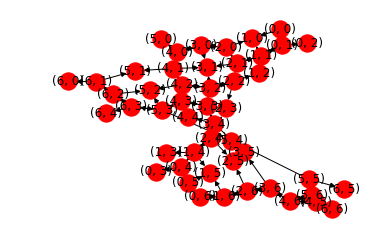

In [452]:
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx_nodes(g,pos)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g,pos)
plt.axis('off')
plt.show()

In [504]:
pos = {node: np.array([node[1], node[0]]) for node in g.nodes()}

In [508]:
sizes = [attr['plays'] for node,attr in g.nodes(data=True)]

In [526]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [523]:
wins = [attr['wins'] for node, attr in g.nodes(data=True)]

In [533]:
norm = Normalize(vmin=min(wins), vmax=max(wins), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.gist_heat_r)
cols = [mapper.to_rgba(v) for v in wins]

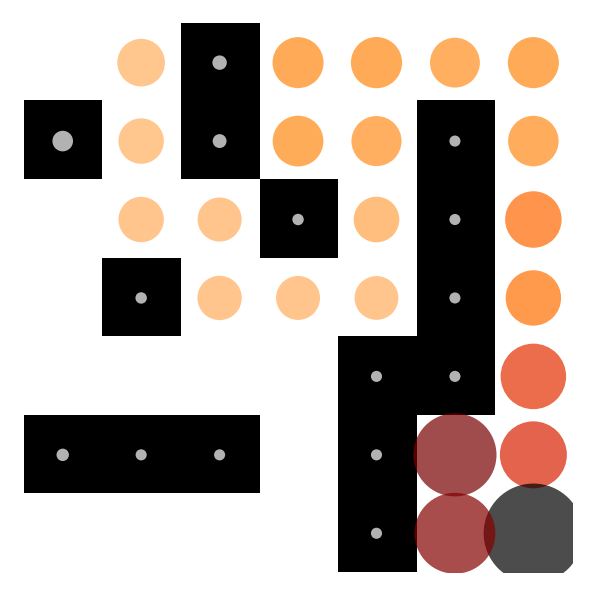

In [535]:
plt.figure(figsize=(10, 8), dpi=200)
plt.subplot(211)

nx.draw_networkx_nodes(g, pos, node_size=sizes, alpha=0.7, linewidths=0, node_color=cols)
# nx.draw_networkx_labels(g, pos)
# nx.draw_networkx_edges(g, pos)
plt.imshow(grid, cmap='gray')
plt.yticks([])
plt.xticks([])
plt.axis('off')
plt.show()